In [57]:
n_past    = 24    # số bước quá khứ (ví dụ: 24 * 5 phút = 2 giờ)
n_future  = 6     # số bước tương lai muốn dự đoán
n_features = 3   # số counter_id muốn dự đoán (tương đương số cột sau pivot)
selected_node_id = 3  # ví dụ chọn node_id = 1

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Giả sử df là DataFrame gốc
df = pd.read_csv("sbc_counter_result.csv")
print(f"Số mẫu: {len(df)}")

def preprocess_data(df, n_features, selected_node_id=None, scaler_type='minmax'):
    """
        Returns:
        data_scaled: numpy (samples, len(counter_id))
        scaler: để inverse_transform
        index_time: index datetime
        feature_names: list counter_id
    """
    # Loại bỏ 2 cột id và counter_option
    df = df.drop(columns=['id', 'counter_option'])
    
    # Chuyển trigger_time thành datetime và set làm index
    df['trigger_time'] = pd.to_datetime(df['trigger_time'], unit='s')
    
    # Nếu muốn làm việc với 1 node cụ thể
    if selected_node_id is not None:
        df = df[df['node_id'] == selected_node_id]
    
    # Pivot: mỗi column là một counter_id, value là counter_value
    # index: trigger_time, columns: counter_id
    df_pivot = df.pivot_table(
        index='trigger_time',
        columns='counter_id',
        values='counter_value'
    )
    
    # Sắp xếp theo thời gian
    df_pivot = df_pivot.sort_index()
    
    # Chọn n_features counter_id đầu tiên (hoặc bạn có thể chọn danh sách cụ thể)
    all_counters = sorted(df_pivot.columns)
    chosen_counters = all_counters[:n_features]
    # df_pivot = df_pivot[chosen_counters]
    
    # Xử lý missing: forward fill rồi drop những dòng vẫn NaN
    df_pivot = df_pivot.ffill().dropna()
    
    # Chuẩn hóa
    if scaler_type == 'standard':
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    else:  # 'minmax'
        scaler = MinMaxScaler(feature_range=(0, 1))
    
    data_scaled = scaler.fit_transform(df_pivot.values)
    
    return data_scaled, scaler, df_pivot.index, chosen_counters

data_scaled, scaler, time_index, feature_names = preprocess_data(
    df,
    n_features=n_features,
    selected_node_id=selected_node_id,
    scaler_type='minmax'
)

print(data_scaled.shape)   # (T, n_features)


Số mẫu: 3145080
(26209, 20)


In [59]:
def create_sequences(data_scaled, n_past, n_future, n_features):
    """
    data_scaled: numpy (T, n_features)
    Trả về:
        X: (samples, n_past, n_features)
        y: (samples, n_future, n_features)
    """
    X, y = [], []
    
    for i in range(n_past, len(data_scaled) - n_future + 1):
        # X: đoạn [i-n_past, i)
        X.append(data_scaled[i - n_past:i, :])
        # y: đoạn [i, i+n_future)
        y.append(data_scaled[i:i + n_future, 0:n_features])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

X, Y = create_sequences(data_scaled, n_past, n_future, n_features)

print("X shape:", X.shape)  # (samples, n_past, n_features)
print("Y shape:", Y.shape)  # (samples, n_future, n_features)


X shape: (26180, 24, 20)
Y shape: (26180, 6, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

# def build_lstm_model(X_train, y_train):
#     model = Sequential()
#     # Encoder
#     model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(Dropout(0.2))
    
#     # Lặp vector ẩn n_future lần (decoder)
#     model.add(RepeatVector(n_future))
    
#     # Decoder
#     model.add(LSTM(64, activation='relu', return_sequences=True))
#     model.add(Dropout(0.2))
    
#     # Output: chuỗi n_future, mỗi bước là n_features
#     model.add(TimeDistributed(Dense(y_train.shape[2])))
    
#     model.compile(optimizer='adam', loss='mse')
#     return model

# def build_lstm_model(X_train, Y_train):
#     model = Sequential()
#     # Input: (24, 20)
#     model.add(
#         LSTM(
#             128,
#             activation='relu',
#             return_sequences=True,              # quan trọng: trả về 24 bước
#             input_shape=(X_train.shape[1], X_train.shape[2])
#         )
#     )
#     model.add(Dropout(0.2))

#     # Có thể thêm 1 LSTM nữa để giảm còn 6 bước
#     model.add(
#         LSTM(
#             64,
#             activation='relu',
#             return_sequences=True               # vẫn cần sequence để TimeDistributed dùng
#         )
#     )
#     model.add(Dropout(0.2))

#     # Output: (6, 3)
#     model.add(TimeDistributed(Dense(Y_train.shape[2])))  # = 3

#     model.compile(optimizer='adam', loss='mse')
#     return model

# model = build_lstm_model(X, Y)
# model.summary()


In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Reshape

def build_lstm_model_v2(X_train, Y_train):
    """
    X_train: (samples, n_past, n_features_in)  = (20944, 24, 20)
    Y_train: (samples, n_future, n_features_out) = (20944, 6, 3)
    """
    n_past         = X_train.shape[1]  # 24
    n_features_in  = X_train.shape[2]  # 20
    n_future       = Y_train.shape[1]  # 6
    n_features_out = Y_train.shape[2]  # 3

    print("n_past:", n_past,
          "n_features_in:", n_features_in,
          "n_future:", n_future,
          "n_features_out:", n_features_out)

    model = Sequential()

    # LSTM 1: trả về chuỗi
    model.add(
        LSTM(
            64,
            activation='relu',
            return_sequences=True,
            input_shape=(n_past, n_features_in)
        )
    )

    # LSTM 2: chỉ lấy hidden state cuối
    model.add(
        LSTM(
            64,
            activation='relu',
            return_sequences=False
        )
    )

    # Dropout
    model.add(Dropout(0.2))

    # Dense: 6 * 3 = 18 units
    model.add(Dense(n_future * n_features_out, name="dense_out"))

    # Reshape: (None, 18) -> (None, 6, 3)
    model.add(Reshape((n_future, n_features_out), name="reshape_out"))

    model.compile(optimizer='adam', loss='mse')
    return model


model = build_lstm_model_v2(X, Y)
model.summary()

n_past: 24 n_features_in: 20 n_future: 6 n_features_out: 3


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 24, 64)         │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 18)             │         1,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_out (Reshape)           │ (None, 6, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,954 (218.57 KB)

 Trainable params: 55,954 (218.57 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Chia train/test theo tỉ lệ 80/20
train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Y_train:", Y_train.shape, "Y_test:", Y_test.shape)

# Huấn luyện
history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


X_train: (20944, 24, 20) X_test: (5236, 24, 20)
Y_train: (20944, 6, 3) Y_test: (5236, 6, 3)
Epoch 1/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0193 - val_loss: 0.0114
Epoch 2/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 3/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 4/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 5/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 6/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 7/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 8/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 9/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 10/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 11/20
590/590 ━━━━━━━━━━━━━━━━━━━

In [87]:
# Dự đoán trên test set (trong không gian đã scale)
Y_pred_scaled = model.predict(X_test)  # (samples_test, n_future, n_features)

print("Y_pred_scaled:", Y_pred_scaled.shape)

# ---- BẮT ĐẦU: Inverse transform cho trường hợp n_features < n_scaler_features ----

# Số features mà scaler đã fit
n_scaler_features = scaler.n_features_in_
print("Scaler được fit với số features:", n_scaler_features)

# 1) Reshape 3D -> 2D
#    Y_test: (n_test, n_future, n_features)
#    Y_pred_scaled: (n_test, n_future, n_features)
n_test, n_future, n_features = Y_test.shape

Y_test_2d  = Y_test.reshape(-1, n_features)         # (n_test * n_future, n_features)
Y_pred_2d  = Y_pred_scaled.reshape(-1, n_features)  # (n_test * n_future, n_features)

# 2) Tạo mảng pad với số cột bằng n_scaler_features
Y_test_pad  = np.zeros((Y_test_2d.shape[0],  n_scaler_features))
Y_pred_pad  = np.zeros((Y_pred_2d.shape[0],  n_scaler_features))

# Giả sử model đang làm việc với n_features cột ĐẦU TIÊN mà scaler fit
Y_test_pad[:, :n_features] = Y_test_2d
Y_pred_pad[:, :n_features] = Y_pred_2d

# 3) Inverse transform trên toàn bộ mảng pad
Y_test_inv_full = scaler.inverse_transform(Y_test_pad)
Y_pred_inv_full = scaler.inverse_transform(Y_pred_pad)

# 4) Cắt lại đúng n_features cột mà model quan tâm
Y_test_inv_2d = Y_test_inv_full[:, :n_features]
Y_pred_inv_2d = Y_pred_inv_full[:, :n_features]

# 5) Reshape lại về 3D như ban đầu
Y_test_inv = Y_test_inv_2d.reshape(n_test, n_future, n_features)
Y_pred_inv = Y_pred_inv_2d.reshape(n_test, n_future, n_features)

# ---- KẾT THÚC ----

print("Y_test_inv shape:", Y_test_inv.shape)
print("Y_pred_inv shape:", Y_pred_inv.shape)


164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Y_pred_scaled: (5236, 6, 3)
Scaler được fit với số features: 20
Y_test_inv shape: (5236, 6, 3)
Y_pred_inv shape: (5236, 6, 3)


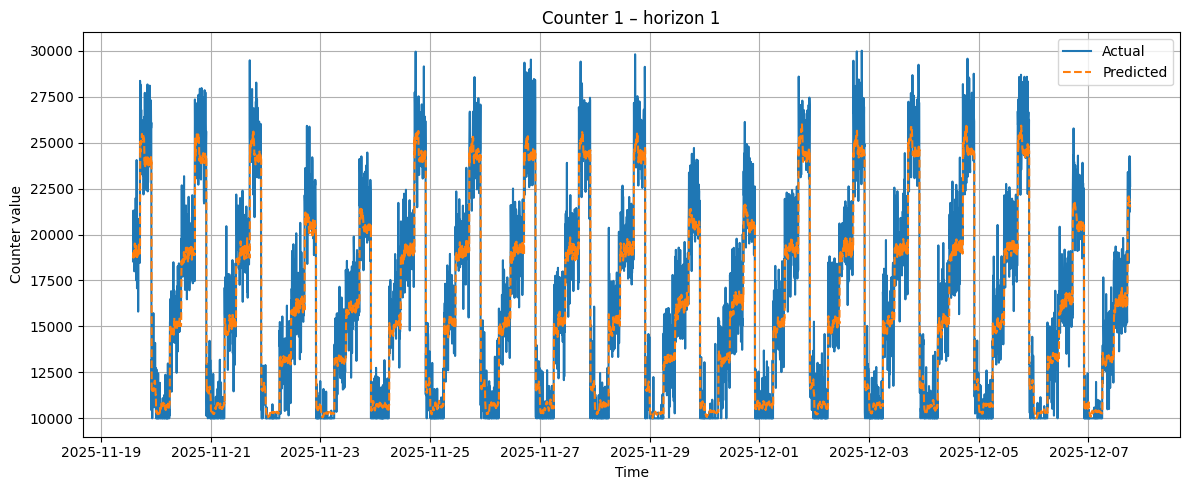

In [88]:
import matplotlib.pyplot as plt

def plot_prediction_vs_actual(
    time_index,
    Y_test_inv,  # (n_test, n_future, n_features)
    Y_pred_inv,
    n_past,
    train_size,
    feature_idx=0,
    horizon=0  # 0: bước đầu tiên trong n_future
):
    n_test, n_future, n_features = Y_test_inv.shape
    
    # Chuỗi thực và dự đoán cho feature_idx ở horizon h
    actual = Y_test_inv[:, horizon, feature_idx]
    pred   = Y_pred_inv[:, horizon, feature_idx]
    
    # Xây dựng index thời gian tương ứng
    # Sample test thứ i → dự đoán cho bước tương lai horizon → time_index[n_past + train_size + i + horizon]
    time_for_points = []
    for i in range(n_test):
        idx = n_past + train_size + i + horizon
        if idx < len(time_index):
            time_for_points.append(time_index[idx])
        else:
            # phòng trường hợp index vượt quá (hiếm khi nếu logic cắt dữ liệu chuẩn thì không bị)
            time_for_points.append(time_index[-1])
    
    # Đưa vào DataFrame cho dễ plot
    plot_df = pd.DataFrame({
        'time': time_for_points,
        'actual': actual,
        'pred': pred
    }).set_index('time')
    
    plt.figure(figsize=(12, 5))
    plt.plot(plot_df.index, plot_df['actual'], label='Actual')
    plt.plot(plot_df.index, plot_df['pred'],   label='Predicted', linestyle='--')
    plt.title(f'Counter {feature_names[feature_idx]} – horizon {horizon+1}')
    plt.xlabel('Time')
    plt.ylabel('Counter value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ví dụ: vẽ cho counter đầu tiên, horizon bước đầu tiên
plot_prediction_vs_actual(
    time_index=time_index,
    Y_test_inv=Y_test_inv,
    Y_pred_inv=Y_pred_inv,
    n_past=n_past,
    train_size=train_size,
    feature_idx=0,   # counter đầu tiên trong feature_names
    horizon=0        # bước 1 trong n_future
)
